# Reconocimiento de Patrones
[Curso de Reconocimiento de Patrones]

Departamento Electrónica

Universidad Popular del Cesar

José Ramón Iglesias



# Ejemplo: Detección de Personas

En este ejercicio se realizará la detección de peatones usando HoG y un clasificador simple KNN.


**ADVERTENCIA:** Este ejercicio tiene fines pedagógicos sólamente, con la idea de que la solución a este problema pueda ejecutarse en un par de minutos. Un buen detector de personas sigue esta idea pero con miles de imágenes por clase.




# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Instalación de PyBalu

[PyBalu](https://github.com/mbucchi/pybalu) es una librería creada para extraer características. 

In [ ]:
from IPython.display import clear_output
!pip install scipy==1.2
!pip3 install pybalu==0.2.5
clear_output()
print('Librería PyBalu instalada.')

Librería PyBalu instalada.


## Setup de librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from   sklearn.metrics import confusion_matrix, accuracy_score
from   sklearn.neighbors import KNeighborsClassifier
from   tqdm.auto import tqdm
from   seaborn import heatmap
from   google.colab.patches import cv2_imshow 
from   pybalu.feature_extraction import hog_features, lbp_features
from   pybalu.feature_transformation import normalize

print('Librerías cargadas.')


Librerías cargadas.


## Funciones necesarias

In [ ]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_char,num_img,echo='off'):
  st   = prefix + num2fixstr(num_char,2) + '_' + num2fixstr(num_img,4) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img


# Separación entre training y testing
def SplitTrainTest(X,y,n):

  K      = np.max(y)+1              # número de clases
  N      = np.int(X.shape[0]/K)     # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),'int') # ground truth del training         
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),'int')  # ground truth del testing  

  # contadores
  itrain = 0
  itest  = 0
  t      = 0

  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1
  
  return Xtrain,ytrain,Xtest,ytest

# Clasificación usando KNN con n_vecinos
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest,n_vecinos=3):
  Xtrain, a, b = normalize(Xtrain)
  Xtest        = Xtest * a + b
  knn = KNeighborsClassifier(n_neighbors=n_vecinos)
  knn.fit(Xtrain, ytrain)
  ypred        = knn.predict(Xtest)
  acc          = accuracy_score(ytest,ypred)
  print('Entrenando con '+str(Xtrain.shape[0])+' muestras y probando con '+str(Xtest.shape[0])+' muestras')
  print('Testing Accuracy = '+str(acc*100)+'%')
  C = confusion_matrix(ytest,ypred)
  print('Matriz de Confusión:')
  print(C)
  return acc,C

# Ejemplo 1: Reconocimiento peatón vs no-peatón

* Clase 0: Personas (peatones)

* Clase 1: No-Personas (fotos de la partes de la ciudad sin personas)

La base de datos contiene 680 imágenes por clase de 160x96 pixeles en escala de grises.


## Carga de base de datos

La base de datos consiste en 2 clases y 120 imágenes por clase. Se almacenan en la carpeta facedetection con el formato face_xx_nnn.png, donde xx es el ID de la clase (01 para caras, 02 para no caras) y nnn es el número de la foto de la clase (01, 02, ... 120). Las fotos son de 160x96 pixeles.

In [ ]:
!wget https://www.dropbox.com/s/zh2en25w9q3jaih/persons.zip
!unzip persons.zip
clear_output()
print('Base de datos personas/no-personas cargada.')

Base de datos personas/no-personas cargada.


Clase Peatón:


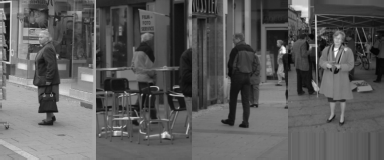


Clase No-Peatón:


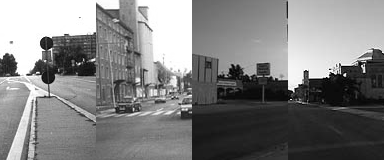

In [ ]:
print('Clase Peatón:')
I1    = 255*ImageLoad('persons/person_',1,10,echo='off')
I2    = 255*ImageLoad('persons/person_',1,15,echo='off')
I3    = 255*ImageLoad('persons/person_',1,25,echo='off')
I4    = 255*ImageLoad('persons/person_',1,35,echo='off')
I = np.concatenate((I1,I2,I3,I4),axis=1)
cv2_imshow(I)

print('')
print('Clase No-Peatón:')
I1    = 255*ImageLoad('persons/person_',2,10,echo='off')
I2    = 255*ImageLoad('persons/person_',2,15,echo='off')
I3    = 255*ImageLoad('persons/person_',2,25,echo='off')
I4    = 255*ImageLoad('persons/person_',2,35,echo='off')
I = np.concatenate((I1,I2,I3,I4),axis=1)
cv2_imshow(I)


## Extracción de características HoG


Con el comando

`f  = hog_features(image, v_windows=v, h_windows=h, n_bins=b)`

se divide la imagen en `v` x `h` celdas, y a cada una de se le extrae un descriptor HoG de `b` bins. El descriptor f tiene `v*h*b` elementos.



In [ ]:
K    = 2     # Numero de clases
N    = 680   # Numero de imagenes por clase
Mhog = 1440  # Numero de elementos del vector HoG

Xhog  = np.zeros((K*N,Mhog))    # K*N muestras (filas), y Mlbp características (columnas)

y     = np.zeros((K*N),'int')   # ground truth (clasificacion ideal)

t = 0
print('Cargando imagenes y extrayendo características...')
for j in range(K):            # para cada clase
  print('Extrayendo características: batch '+str(j+1)+'/'+str(K))
  for i in tqdm(range(N)):                # para cada imagen de la clase
    # Lectura de la imagen
    img    = 255*ImageLoad('persons/person_',j+1,i+1,echo='off')

    # Extracción de HoG
    Xhog[t,:] = hog_features(img, v_windows=16, h_windows=10, n_bins=9) 
    y[t] = j # la muestra t pertenece a la clase j
    t = t+1

Cargando imagenes y extrayendo características...
Extrayendo características: batch 1/2



Extrayendo características: batch 2/2


## Clasificación usando HoG

600 imágenes por clase para training y 80 imágenes por clase para testing.

Entrenando con 1200 muestras y probando con 160 muestras
Testing Accuracy = 91.875%
Matriz de Confusión:
[[74  6]
 [ 7 73]]


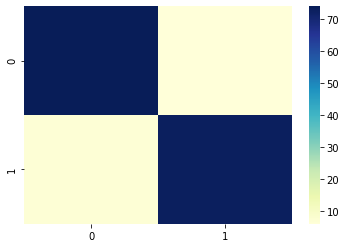

In [ ]:
# Paso 1: definir X
X = Xhog

# Paso 2: separar training/testing
ntrain = 600 
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain) 

# Paso 3: clasificar y evaluar desempeño
acc,C = ClassifierKNN(Xtrain,ytrain,Xtest,ytest)

heatmap(C, cmap="YlGnBu")

# Ejemplo 2: peatón - no-peatón - peatón con bicicleta


* Clase 0: Personas (peatones)

* Clase 1: No-Personas (fotos de la partes de la ciudad sin personas)

* Clase 2: Peatones con bicicleta


La base de datos contiene 254 imágenes por clase de 160x96 pixeles en escala de grises.


## Carga de base de datos

In [ ]:
!wget https://www.dropbox.com/s/8414rxqvk608c4t/bikes.zip
!unzip bikes.zip
clear_output()
print('Base de datos personas/no-personas/personas con bicicletas cargada.')

Base de datos personas/no-personas/personas con bicicletas cargada.


Clase Peatón:


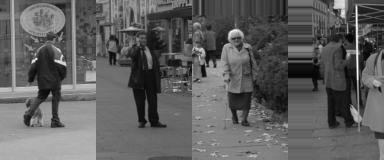


Clase No-Peatón:


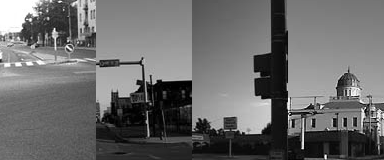


Clase Peatón-con-Bicicleta:


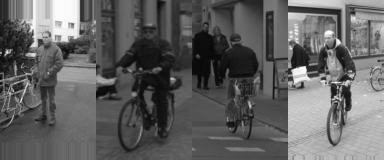

In [ ]:
print('Clase Peatón:')
I1    = 255*ImageLoad('bikes/person_',1, 7,echo='off')
I2    = 255*ImageLoad('bikes/person_',1,17,echo='off')
I3    = 255*ImageLoad('bikes/person_',1,27,echo='off')
I4    = 255*ImageLoad('bikes/person_',1,37,echo='off')
I = np.concatenate((I1,I2,I3,I4),axis=1)
cv2_imshow(I)

print('')
print('Clase No-Peatón:')
I1    = 255*ImageLoad('bikes/person_',2, 7,echo='off')
I2    = 255*ImageLoad('bikes/person_',2,17,echo='off')
I3    = 255*ImageLoad('bikes/person_',2,27,echo='off')
I4    = 255*ImageLoad('bikes/person_',2,37,echo='off')
I = np.concatenate((I1,I2,I3,I4),axis=1)
cv2_imshow(I)

print('')
print('Clase Peatón-con-Bicicleta:')
I1    = 255*ImageLoad('bikes/person_',3, 7,echo='off')
I2    = 255*ImageLoad('bikes/person_',3,17,echo='off')
I3    = 255*ImageLoad('bikes/person_',3,27,echo='off')
I4    = 255*ImageLoad('bikes/person_',3,37,echo='off')
I = np.concatenate((I1,I2,I3,I4),axis=1)
cv2_imshow(I)


## Extracción de características HoG

In [ ]:
K    = 3     # Numero de clases
N    = 254   # Numero de imagenes por clase
Mhog = 1440  # Numero de elementos del vector HoG

Xhog  = np.zeros((K*N,Mhog))    # K*N muestras (filas), y Mlbp características (columnas)

y     = np.zeros((K*N),'int')   # ground truth (clasificacion ideal)

t = 0
print('Cargando imagenes y extrayendo características...')
for j in range(K):            # para cada clase
  print('Extrayendo características: batch '+str(j+1)+'/'+str(K))
  for i in tqdm(range(N)):                # para cada imagen de la clase
    # Lectura de la imagen
    img    = 255*ImageLoad('bikes/person_',j+1,i+1,echo='off')

    # Extracción de HoG
    Xhog[t,:] = hog_features(img, v_windows=16, h_windows=10, n_bins=9) 
    y[t] = j # la muestra t pertenece a la clase j
    t = t+1

Cargando imagenes y extrayendo características...
Extrayendo características: batch 1/3



Extrayendo características: batch 2/3



Extrayendo características: batch 3/3


## Clasificación usando HoG

230 imágenes por clase para training y 24 imágenes por clase para testing.

Entrenando con 690 muestras y probando con 72 muestras
Testing Accuracy = 87.5%
Matriz de Confusión:
[[24  0  0]
 [ 2 22  0]
 [ 7  0 17]]


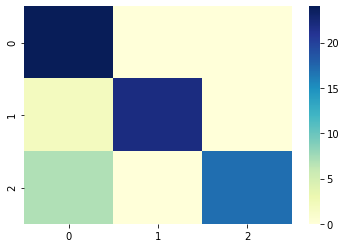

In [ ]:
# Paso 1: definir X
X = Xhog

# Paso 2: separar training/testing
ntrain = 230 
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain) 

# Paso 3: clasificar y evaluar desempeño
acc,C = ClassifierKNN(Xtrain,ytrain,Xtest,ytest)

heatmap(C, cmap="YlGnBu")